In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import time
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations
from catboost import CatBoostClassifier, cv, Pool 
from tqdm.notebook import tqdm

In [2]:
from sklearn.base import clone

In [3]:
np.set_printoptions(precision=5)
pd.set_option('display.max_rows', 100)

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# EDA

In [5]:
df_train.sample(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
11048,11049,2494,0,10,134,54,1209,206,222,154,...,0,0,0,0,0,0,0,0,0,3
2553,2554,2050,287,21,42,12,691,159,234,214,...,0,0,0,0,0,0,0,0,0,4
13502,13503,3049,64,24,531,39,571,233,184,70,...,0,0,0,0,0,0,0,0,0,1
9436,9437,3247,40,11,30,5,3097,221,216,129,...,0,0,0,0,0,0,0,0,0,7
4939,4940,2268,290,26,277,87,1054,139,226,223,...,0,0,0,0,0,0,0,0,0,3


In [6]:
df_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

Aspect


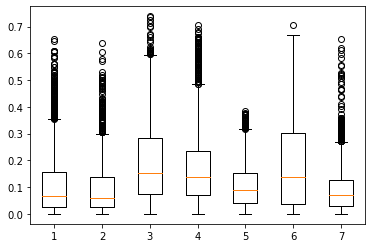

Slope


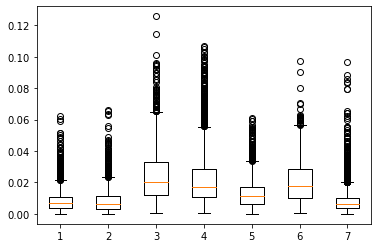

Horizontal_Distance_To_Hydrology


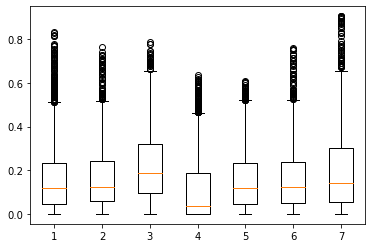

Vertical_Distance_To_Hydrology


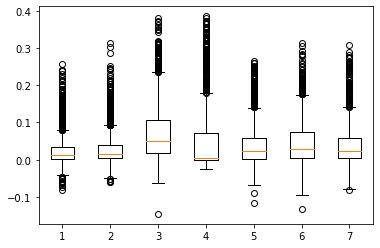

Hillshade_9am


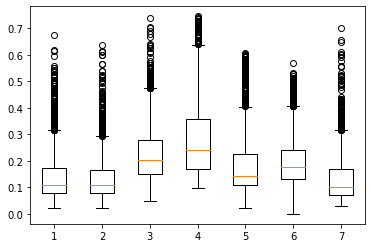

Hillshade_Noon


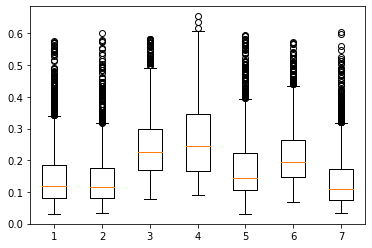

Hillshade_3pm


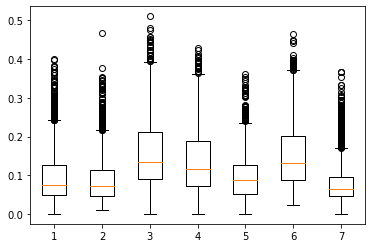

Horizontal_Distance_To_Fire_Points


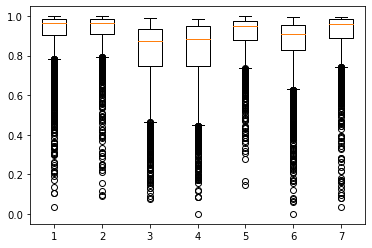

In [11]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
for col in col_normalize:
    print(col)
    l = []
    for cover in sorted(df_train_norm.Cover_Type.unique()):
        l.append( [v for v,k in zip(df_train_norm[col],df_train_norm['Cover_Type']) if k==cover]
                )
    plt.boxplot(l)
    plt.show()

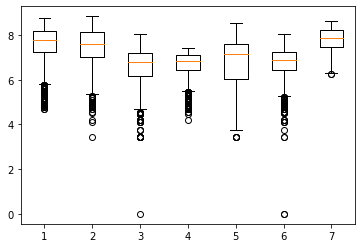

In [8]:
l = []
for cover in sorted(df_train_norm.Cover_Type.unique()):
    l.append( [math.log(v+1) for v,k in zip(df_train_norm['Horizontal_Distance_To_Roadways'],df_train_norm['Cover_Type']) if k==cover]
            )
plt.boxplot(l)
plt.show()

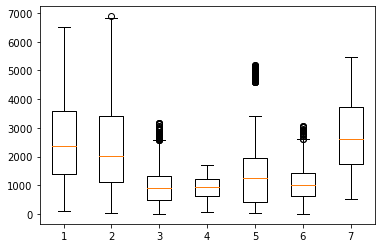

In [9]:
l = []
for cover in sorted(df_train_norm.Cover_Type.unique()):
    l.append( [v for v,k in zip(df_train_norm['Horizontal_Distance_To_Roadways'],df_train_norm['Cover_Type']) if k==cover]
            )
plt.boxplot(l)
plt.show()

results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = PCA(n_components=k)
    pca.fit(df_train_norm.to_numpy(), df_train_norm['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [769]:
soils = [x for x in df_train_norm.columns if "Soil" in x]

for x in combinations(soils, 3):
    print(x)
    break

df_train_norm[soils].sum(axis=1).value_counts()

from tqdm.notebook import tqdm

classes = []
for n in tqdm(range(2,6)):
    for x in tqdm(combinations(soils, n)):
        pca = PCA(n_components=1)
        pca.fit(df_train_norm[list(x)].to_numpy(), df_train_norm['Cover_Type'].to_numpy())
        explained_variance = pca.explained_variance_ratio_.sum()
        classes.append([*x] + [" "]*(5-n) + [explained_variance])

r = pd.DataFrame(classes, columns=['S1','S2','S3','S4','S5','var'])
r['var'] -= 1
r[r['var']>=0].sort_values('var',ascending=False)

r.sort_values('var',ascending=False).to_csv('PCA results.csv', index=False)

results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = TruncatedSVD(n_components=k)
    pca.fit(df_train_norm.to_numpy(), df_train_norm['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

# Helper Funtions

In [5]:
kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)

In [6]:
def pipeline(df, version=0):
    # 0.8658068783068783
    df_n = df.copy()
    df_n.drop(columns=['Id'],inplace=True)
    df_n = df_n.astype({c:'bool' for c in df_n.columns if "Soil_Type" in c or "Wilderness_Area" in c})
    if version >= 1: # 0.893320105820106
        col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                     'Horizontal_Distance_To_Roadways']
        df_n['log_Horizontal_Distance_To_Roadways'] = np.log(df_n['Horizontal_Distance_To_Roadways']+1)
        df_n['log_Horizontal_Distance_To_Fire_Points'] = np.log(df_n['Horizontal_Distance_To_Fire_Points']+1)
        df_n[col_normalize] = normalize(df_n[col_normalize])
        df_n.drop(columns=['Soil_Type7'],inplace=True)
    if version >= 2: # 0.8964947089947091
        df_n['sq_Elevation'] = np.power(df['Elevation'],1.5)
        df_n.drop(columns='Aspect',inplace=True)
        df_n['norm_aspect'] = df.Aspect.map(lambda x: x-180 if x > 180 else x+180)
        df_n['atan_aspect'] = np.arctan(df_n.norm_aspect)y
    if version >= 3: # 0.9104497354497356
        df_n['Vertical_Distance_To_Hydrology'] = np.abs(df_n.Vertical_Distance_To_Hydrology)
        df_n['E-VH'] = df.Elevation - df.Vertical_Distance_To_Hydrology * .9 
        df_n['E-HH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * .5
        
        df_n['F+R'] = (df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Roadways) ** 2
        df_n['F+H'] = (df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Hydrology) ** 0.3
        df_n['H+R'] = (df.Horizontal_Distance_To_Hydrology + df.Horizontal_Distance_To_Roadways)
        
        df_n['abs_H-R'] = (np.abs(df.Horizontal_Distance_To_Hydrology - df.Horizontal_Distance_To_Roadways)) 
        df_n['abs_H-F'] = (np.abs(df.Horizontal_Distance_To_Hydrology - df.Horizontal_Distance_To_Fire_Points)) 
        df_n['abs_F-R'] = (np.abs(df.Horizontal_Distance_To_Fire_Points - df.Horizontal_Distance_To_Roadways)) 
    return df_n

def submit(model,version):
    global df_train
    df_train_c = pipeline(df_train.copy(),version)
    df_submit = pipeline(df_test.copy(),version)
    X, Y = df_train_c.drop(columns=['Cover_Type']).to_numpy(), df_train_c.Cover_Type.to_numpy()
    model.fit(X, Y)
    pred = model.predict(df_submit.to_numpy())
    final_df = df_test.copy()
    final_df['Cover_Type'] = pred
    return final_df[['Id','Cover_Type']]

def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False, return_cv_acc=False, verbose=True, single_split=False, return_class_acc=False):
    X , Y = df.drop(columns=['Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    if single_split or return_class_acc:
        X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        acc = accuracy_score(y_val, pred)
    end = time.time()
    cv_acc = results.mean()
    if verbose:
        print('cv acc:', cv_acc)
        if single_split:
            print('split acc:', acc)
        print('time taken:', end-start, end='\n\n')
    if display:
        matrix = cm(y_val, pred)
        print(matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_cv_acc:
        return_data += [cv_acc]
    if return_time:
        return_data += [end-start]
    if return_class_acc:
        matrix = cm(y_val, pred)
        ca = matrix.diagonal() / matrix.sum(axis=1)
        return_data += [ca]
    return tuple(return_data)

# Baseline

### Best Model = ExtraTreesClassifier()

cv acc: 0.8658068783068783
split acc: 0.8482965931863727
time taken: 14.883414268493652
[0.7571  0.67234 0.81818 0.96078 0.92533 0.84469 0.96073]


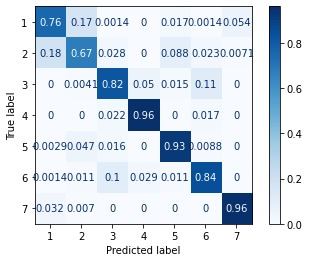

cv acc: 0.8642195767195766
split acc: 0.8434869739478958
time taken: 435.17900037765503
[0.75852 0.63262 0.82632 0.95798 0.93997 0.82834 0.96213]


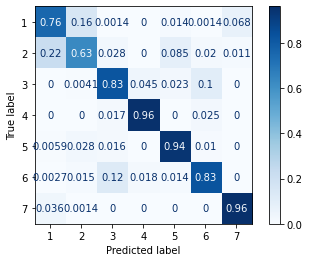

cv acc: 0.8653439153439153
split acc: 0.8448897795591183
time taken: 11.589077472686768
[0.76278 0.6766  0.81004 0.96078 0.92972 0.81744 0.95933]


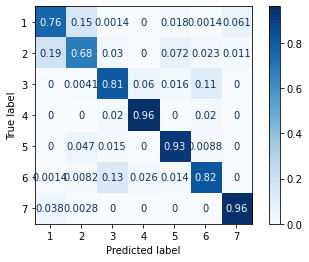

In [781]:
models = []
for clf in [ExtraTreesClassifier(n_jobs=-1, random_state=0),
           HistGradientBoostingClassifier(random_state=0),
           RandomForestClassifier(n_jobs=-1, random_state=0)]:
    
    models.append(score_model(clf,df_train))

### Best Ensemble = Mix 3

cv acc: 0.8854497354497355
split acc: 0.8639278557114228
time taken: 79.07685208320618
[0.76847 0.68936 0.85075 0.96779 0.94876 0.8515  0.97195]


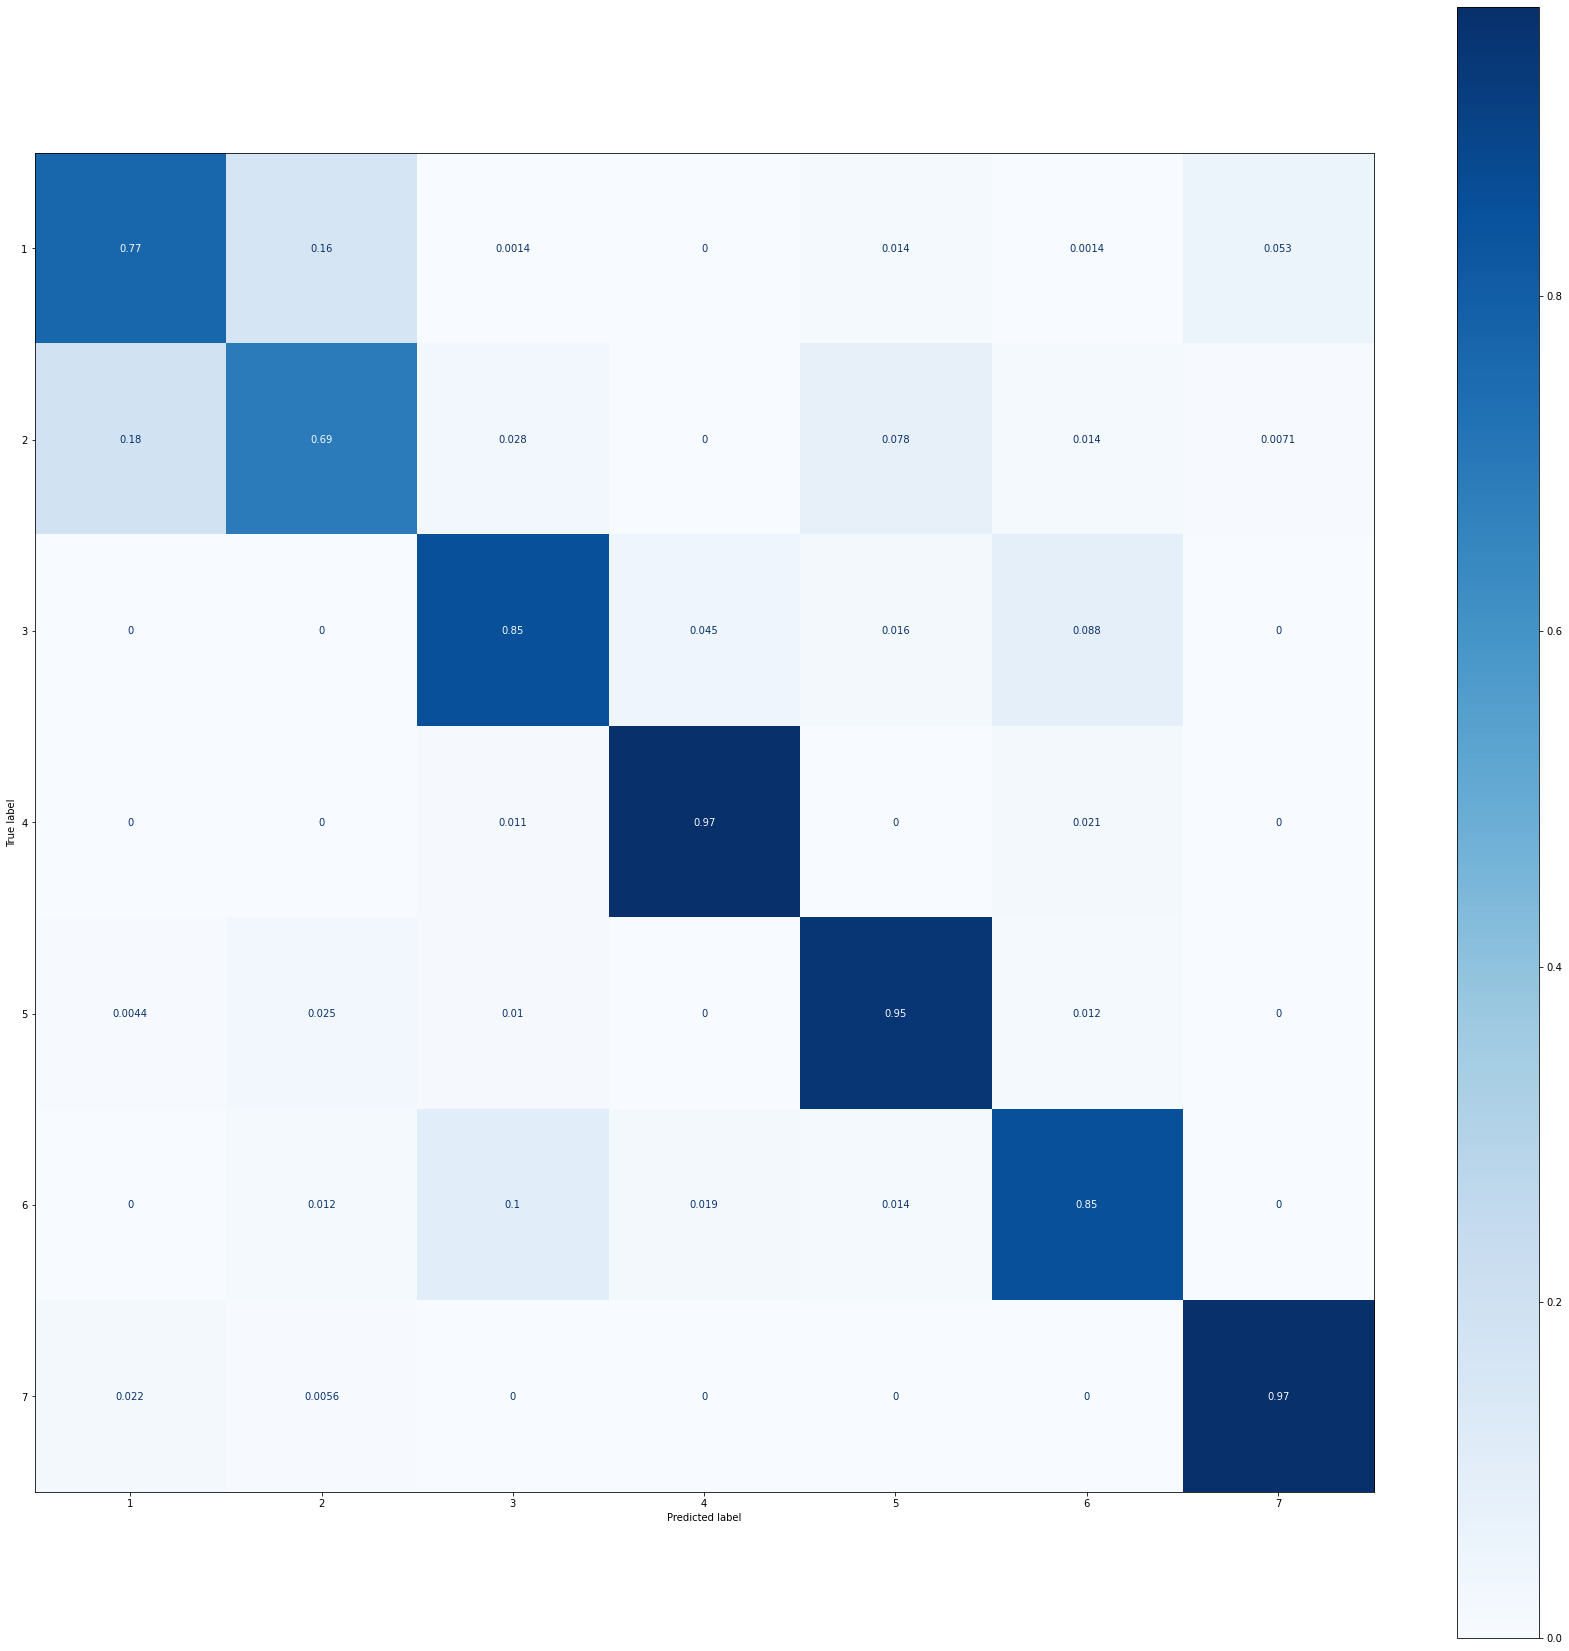

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                 

In [302]:
# Voting
models = [('et',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('hg',HistGradientBoostingClassifier(random_state=0)),
           ('rf',RandomForestClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8659391534391535
split acc: 0.8466933867735471
time taken: 76.25454878807068
[0.74858 0.65532 0.82904 0.96218 0.93411 0.84332 0.95512]


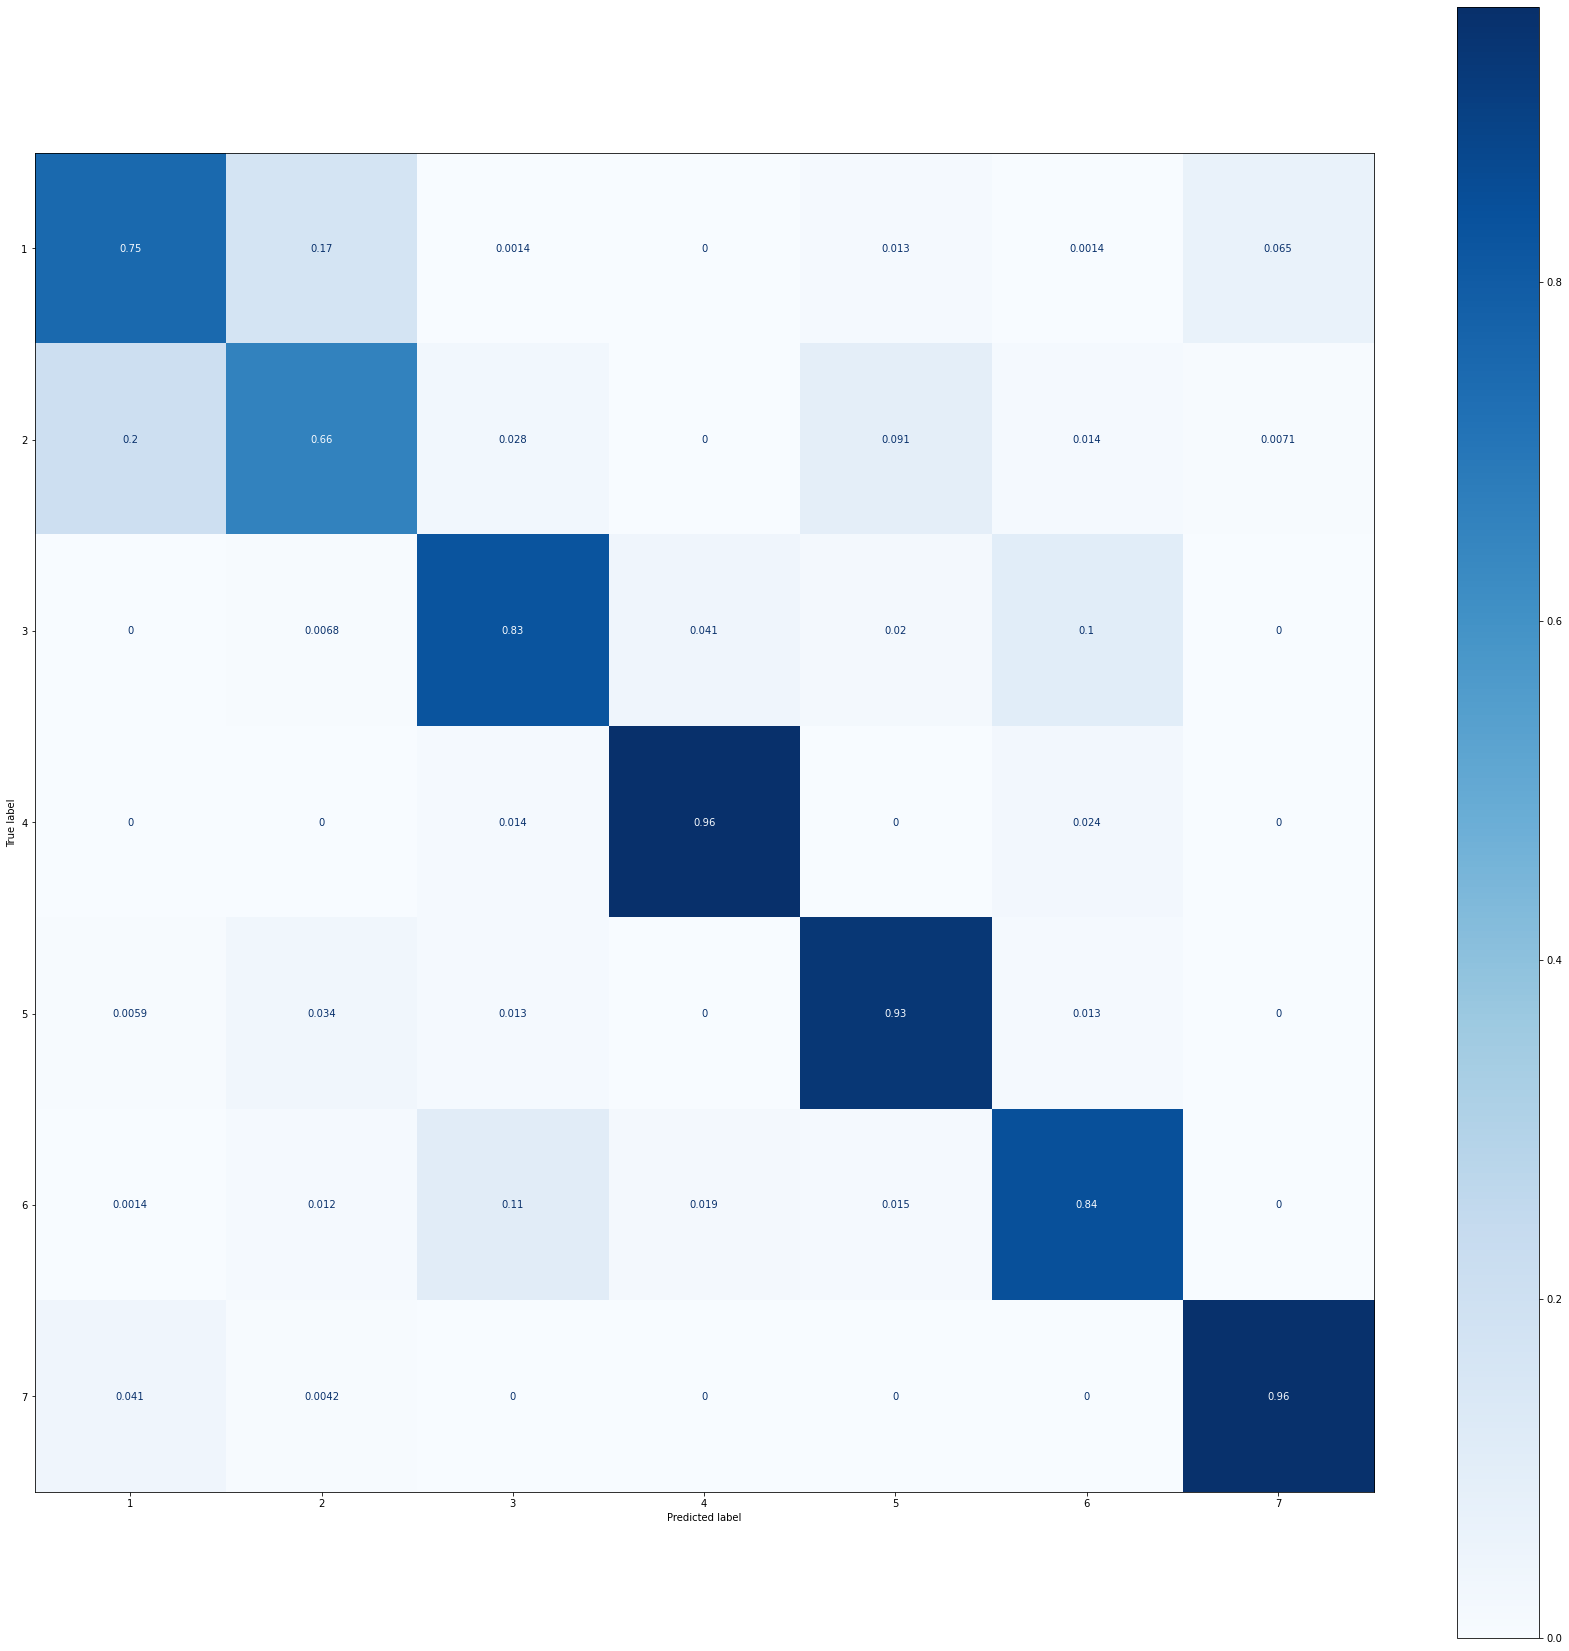

VotingClassifier(estimators=[('hg1',
                              HistGradientBoostingClassifier(l2_regularization=0.0,
                                                             learning_rate=0.1,
                                                             loss='auto',
                                                             max_bins=255,
                                                             max_depth=None,
                                                             max_iter=100,
                                                             max_leaf_nodes=31,
                                                             min_samples_leaf=20,
                                                             n_iter_no_change=None,
                                                             random_state=0,
                                                             scoring=None,
                                                             tol=1e-07,
                            

In [303]:
# Voting
models = [('hg1',HistGradientBoostingClassifier(random_state=0)),
           ('hg2',HistGradientBoostingClassifier(random_state=0)),
           ('hg3',HistGradientBoostingClassifier(random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8873677248677249
split acc: 0.8681362725450902
time taken: 25.90005135536194
[0.74574 0.71915 0.86296 0.96779 0.94729 0.85831 0.97616]


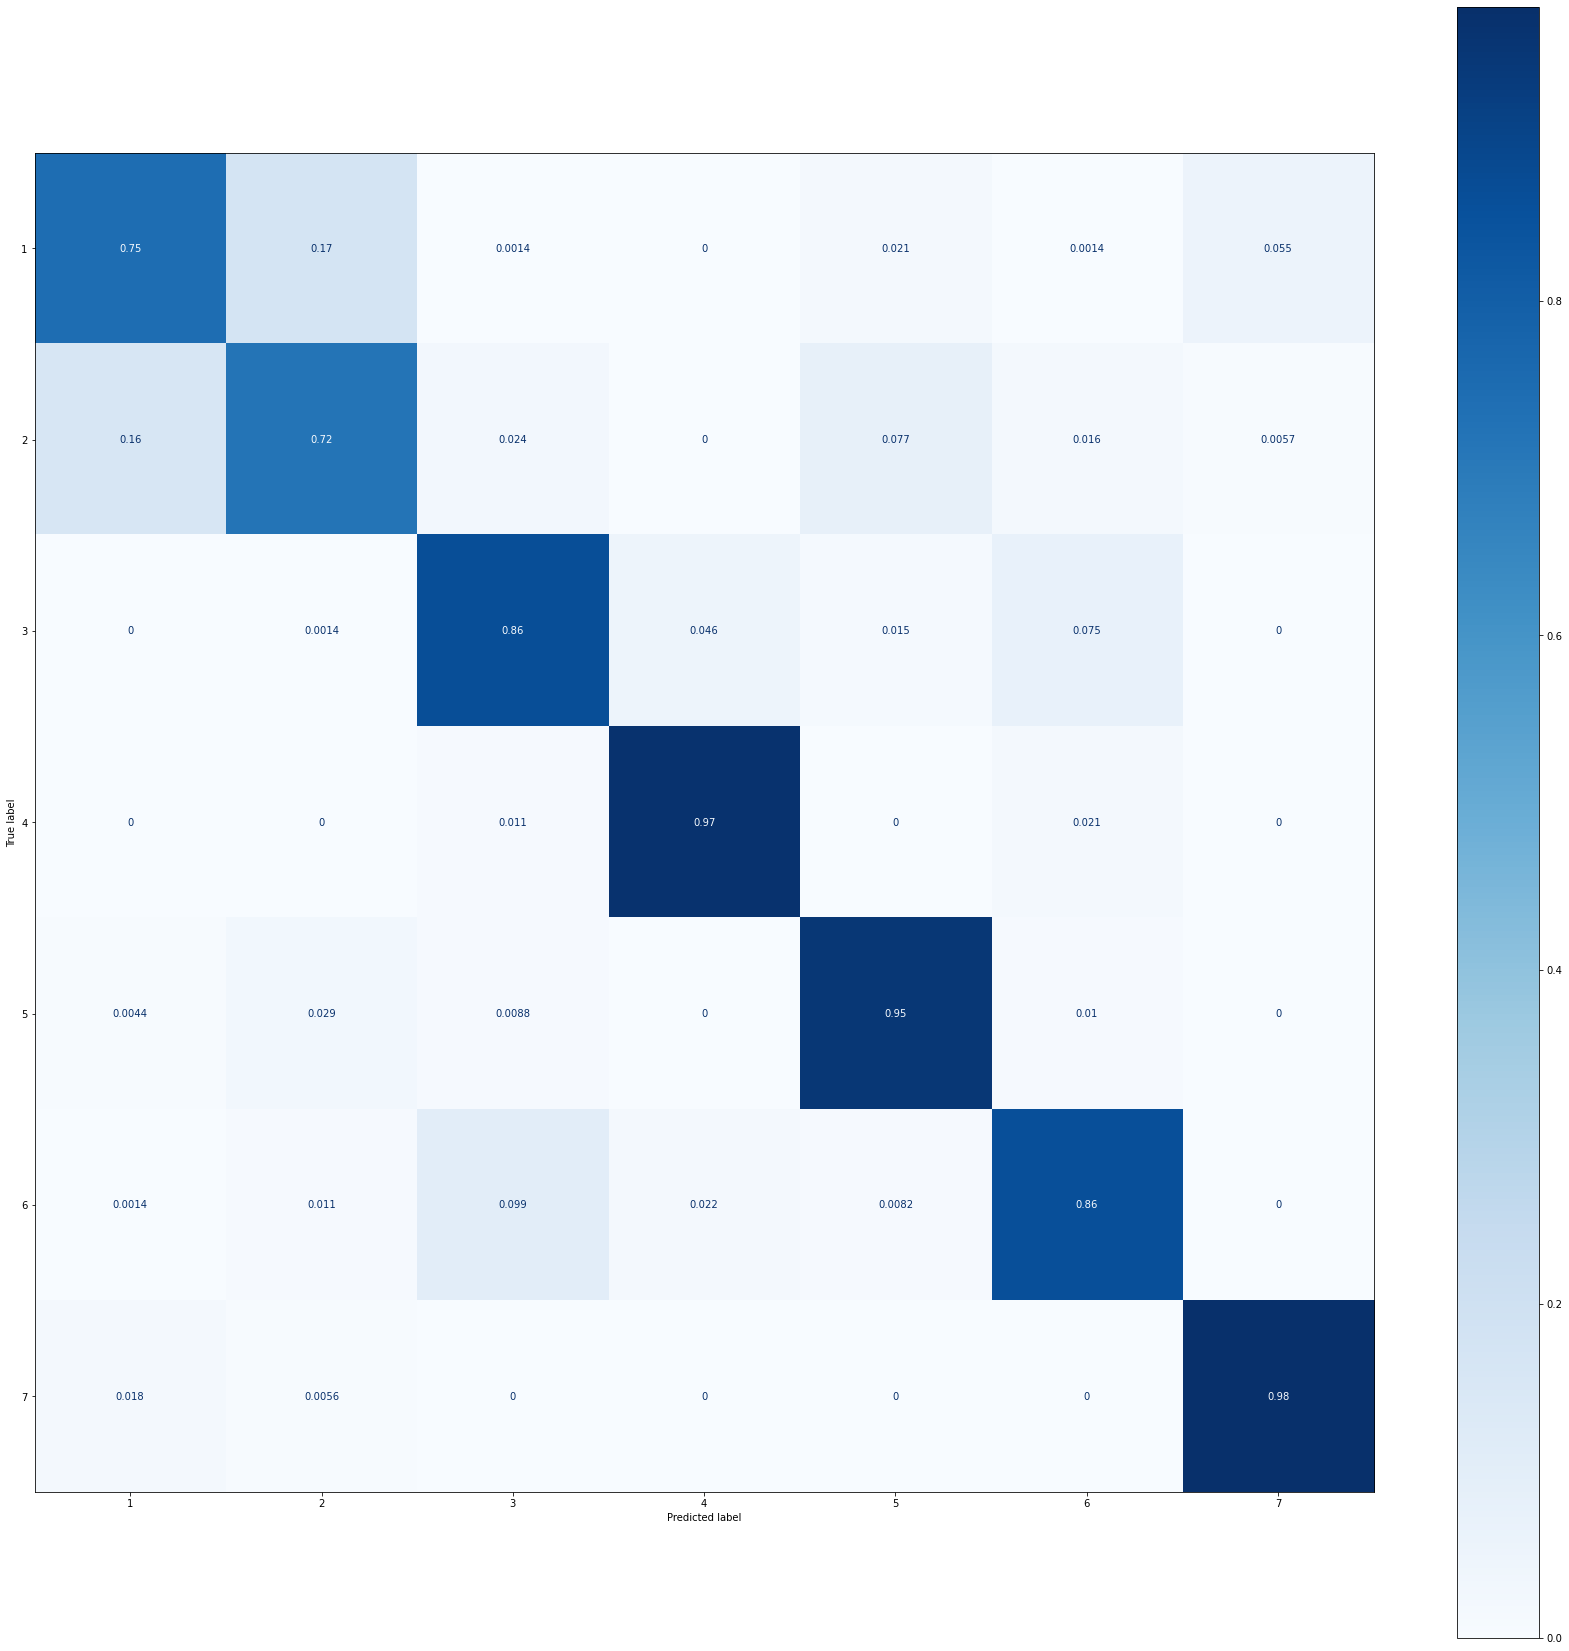

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                 

In [304]:
# Voting
models = [('et',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('et2',ExtraTreesClassifier(n_jobs=-1, random_state=0)),
           ('et3',ExtraTreesClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

cv acc: 0.8774470899470901
split acc: 0.8585170340681363
time taken: 16.610207080841064
[0.76989 0.68794 0.83718 0.96218 0.9429  0.84332 0.96774]


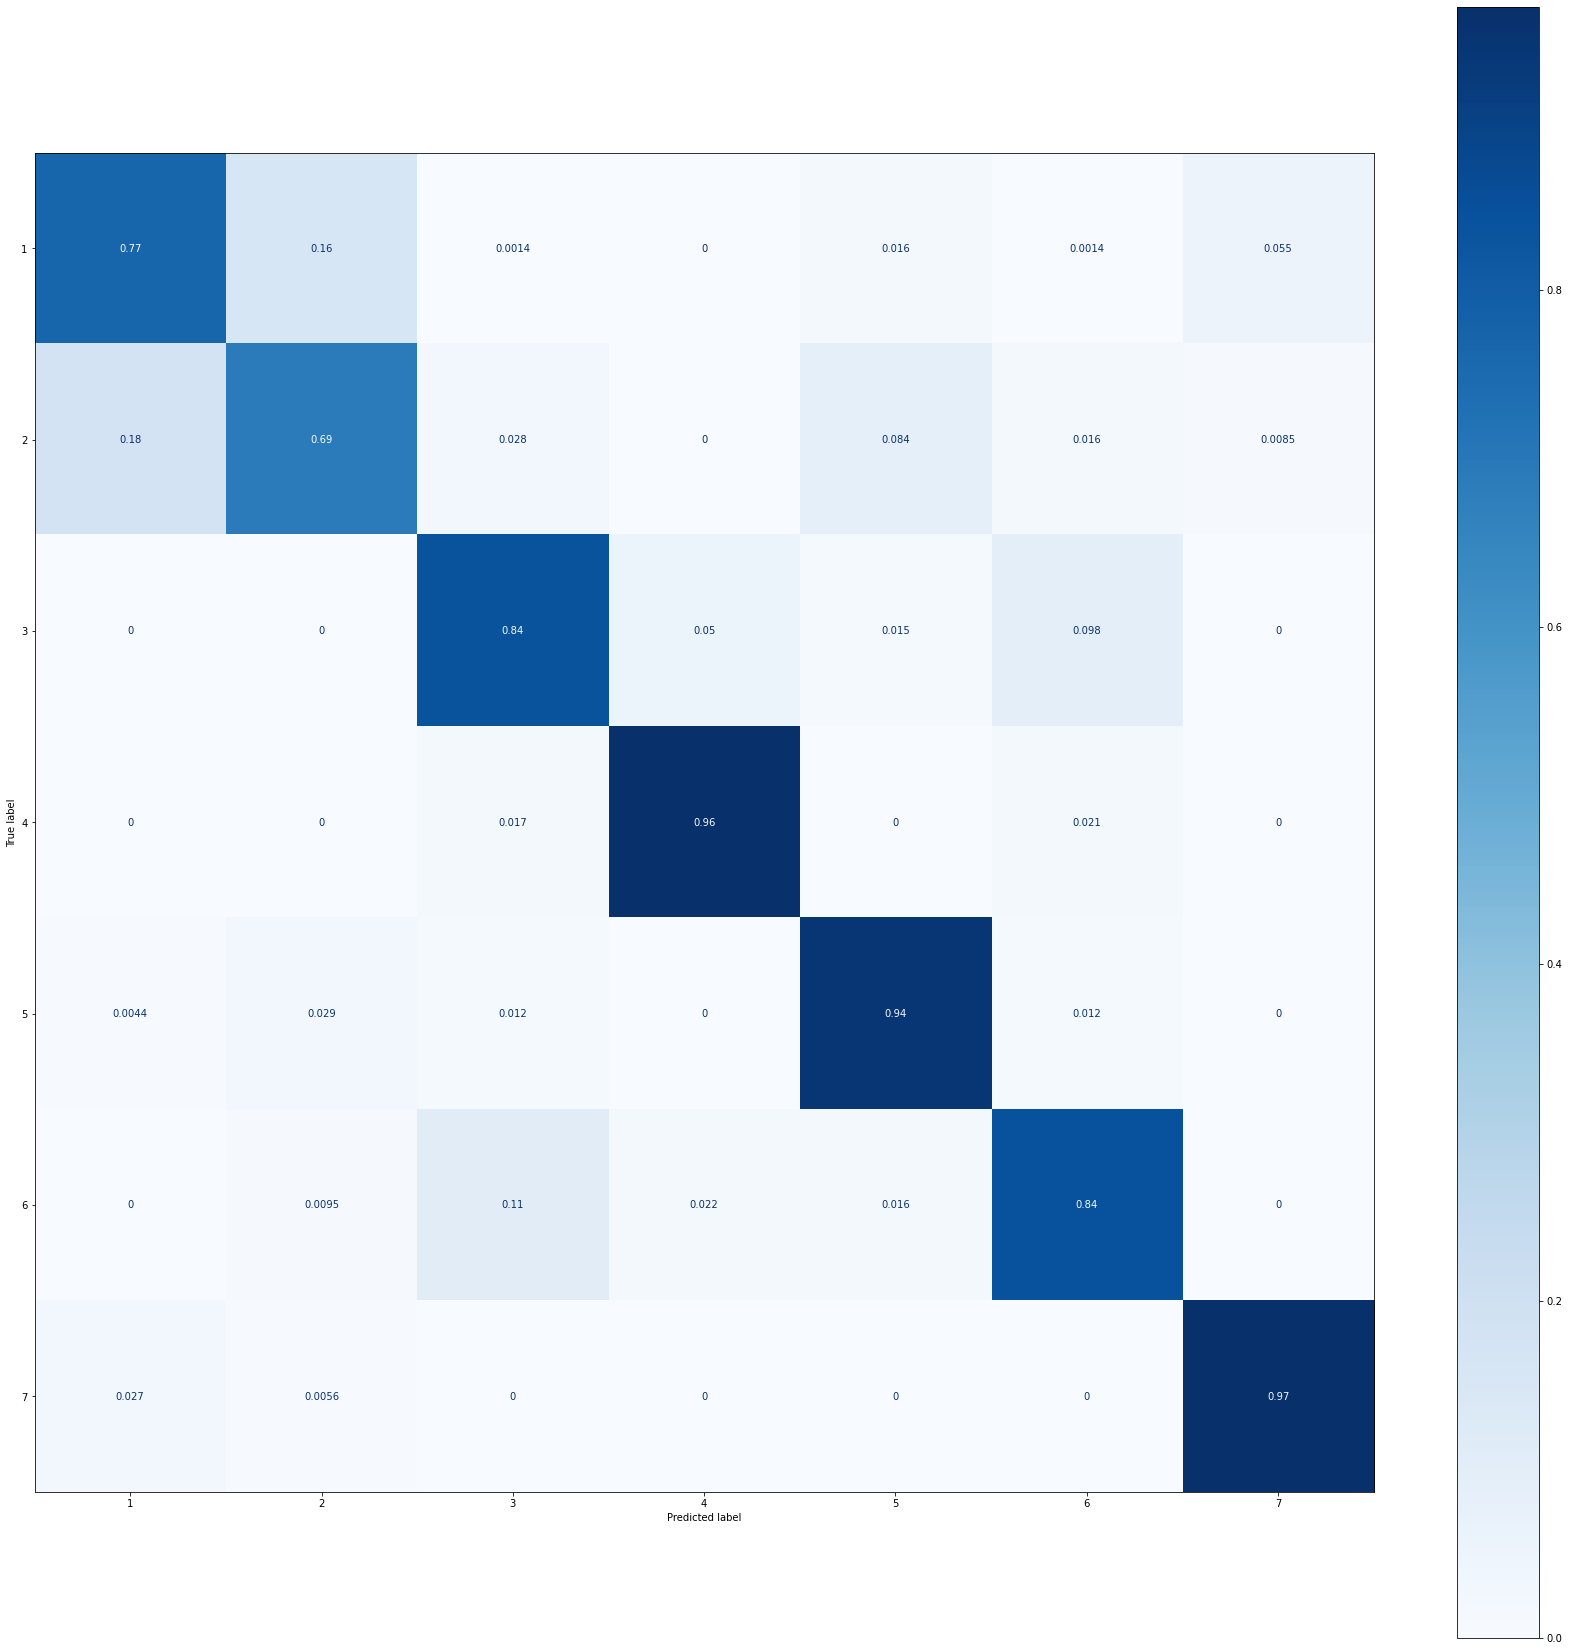

VotingClassifier(estimators=[('rf1',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
       

In [305]:
# Voting
models = [('rf1',RandomForestClassifier(n_jobs=-1, random_state=0)),
           ('rf2',RandomForestClassifier(n_jobs=-1, random_state=0)),
           ('rf3',RandomForestClassifier(n_jobs=-1, random_state=0))]
model = VotingClassifier(models, n_jobs=-1)
score_model(model,df_train);

# Feature Selection

## Alt2

0
cv acc: 0.8683201058201057
split acc: 0.8519038076152304
time taken: 5.991982698440552

[0.75568 0.68227 0.81954 0.96499 0.92387 0.85695 0.96073]


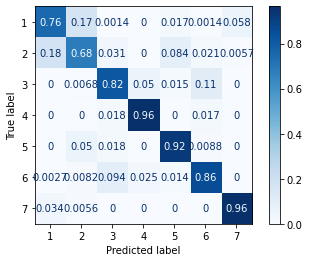

1
cv acc: 0.8909391534391535
split acc: 0.8755511022044088
time taken: 5.786226511001587

[0.75994 0.73475 0.87517 0.96919 0.95608 0.86104 0.97335]


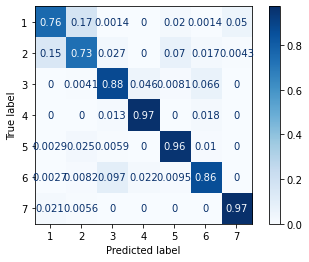

2
cv acc: 0.8965608465608467
split acc: 0.8771543086172344
time taken: 5.622957706451416

[0.78835 0.71915 0.87788 0.97199 0.95461 0.85422 0.97475]


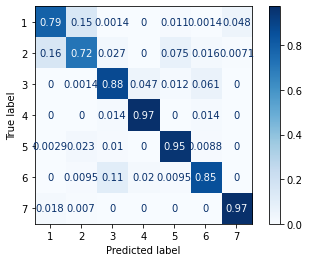

3
cv acc: 0.9111111111111111
split acc: 0.8911823647294589
time taken: 5.181762218475342

[0.80966 0.74752 0.89688 0.97199 0.96633 0.86921 0.97756]


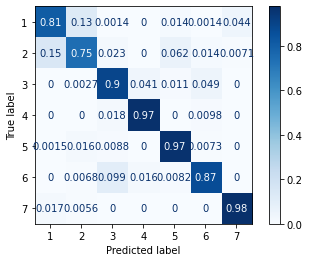

In [12]:
for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    best_m, best_X_train, best_y_train, best_X_val, best_y_val = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=1189), df_train_norm, return_train = True, return_val = True, display=True)

In [342]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= r"http://stream1.cmatc.cn/pub/comet/FireWeather/S290Unit10FuelMoisture/comet/fire/s290/unit10/media/graphics/aspsumm.jpg")

In [195]:
df_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

cv acc: 0.9111111111111111
split acc: 0.8911823647294589
time taken: 5.252859830856323

[0.80966 0.74752 0.89688 0.97199 0.96633 0.86921 0.97756]


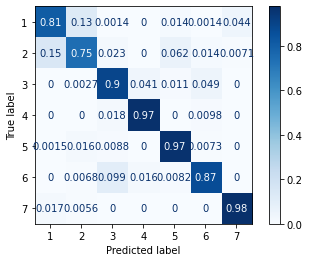

In [10]:
model = ExtraTreesClassifier(n_jobs=-1, random_state=1189)
df_train_norm = pipeline(df_train, 3)
_, cv_acc = score_model(model,df_train_norm, display=True, return_cv_acc=True, verbose=True);

In [151]:
good_rs = [x for x in sorted(good_rs, reverse=True)]
good_rs[0]

[0.9111111111111111, 1189]

In [158]:
# Get good Random_state for Voting Model
results = []
for x in range(6001,7001):
    print(x, end='           \r', flush=True)
    model = ExtraTreesClassifier(n_jobs=-1, random_state=x)
    df_train_norm = pipeline(df_train, 3)
    _, cv_acc = score_model(model,df_train_norm, display=False, return_cv_acc=True, verbose=False);
    results.append([cv_acc,x])
grs = [r for r in results if r[0] > .91]
print(len(grs),' '*50)
good_rs = [x for x in sorted(good_rs+grs, reverse=True)]
print(len(good_rs),' '*50)
print(good_rs[0])

8                                                   
49                                                   
[0.9111111111111111, 1189]


In [14]:
results_1 = [[0.9111111111111111, [1189]],
 [0.9117724867724867, [1189, 883]],
 [0.9124338624338624, [1189, 883, 2153]],
 [0.9116402116402116, [1189, 883, 2153, 5568]],
 [0.9123015873015874, [1189, 883, 2153, 5568, 2077]],
 [0.9130291005291007, [1189, 883, 2153, 5568, 2077, 769]],
 [0.9122354497354499, [1189, 883, 2153, 5568, 2077, 769, 2223]],
 [0.9130952380952382, [1189, 883, 2153, 5568, 2077, 769, 2223, 2675]],
 [0.9121693121693122, [1189, 883, 2153, 5568, 2077, 769, 2223, 2675, 995]],
 [0.9119708994708994, [1189, 883, 2153, 5568, 2077, 769, 2223, 2675, 995, 0]],
 [0.9121693121693122,
  [1189, 883, 2153, 5568, 2077, 769, 2223, 2675, 995, 0, 6890]],
 [0.9123677248677249,
  [1189, 883, 2153, 5568, 2077, 769, 2223, 2675, 995, 0, 6890, 1612]],
 [0.912037037037037,
  [1189, 883, 2153, 5568, 2077, 769, 2223, 2675, 995, 0, 6890, 1612, 1548]],
 [0.9123015873015874,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109]],
 [0.9119047619047619,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529]],
 [0.9121031746031745,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389]],
 [0.9117724867724867,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073]],
 [0.9121031746031747,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040]],
 [0.9118386243386244,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915]],
 [0.9121031746031747,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910]],
 [0.9119708994708994,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910,
   5680]],
 [0.9117063492063492,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910,
   5680,
   4069]],
 [0.9118386243386242,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910,
   5680,
   4069,
   3010]],
 [0.9115740740740741,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910,
   5680,
   4069,
   3010,
   1678]],
 [0.9116402116402117,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910,
   5680,
   4069,
   3010,
   1678,
   1347]],
 [0.9113756613756614,
  [1189,
   883,
   2153,
   5568,
   2077,
   769,
   2223,
   2675,
   995,
   0,
   6890,
   1612,
   1548,
   2109,
   1529,
   389,
   3073,
   1040,
   5915,
   5910,
   5680,
   4069,
   3010,
   1678,
   1347,
   729]]]

good_rs = [[0.9111111111111111, 1189],
 [0.9109788359788361, 883],
 [0.9108465608465609, 2153],
 [0.9107804232804233, 5568],
 [0.9106481481481481, 2077],
 [0.9106481481481481, 769],
 [0.9105820105820104, 2223],
 [0.9105158730158729, 2675],
 [0.9105158730158729, 995],
 [0.9104497354497356, 0],
 [0.9104497354497354, 6890],
 [0.9104497354497354, 1612],
 [0.9104497354497354, 1548],
 [0.9103835978835979, 2109],
 [0.9103835978835979, 1529],
 [0.9103835978835979, 389],
 [0.9103835978835978, 3073],
 [0.9103174603174604, 1040],
 [0.9103174603174603, 5915],
 [0.9102513227513228, 5910],
 [0.9102513227513228, 5680],
 [0.9102513227513228, 4069],
 [0.9102513227513228, 3010],
 [0.9102513227513228, 1678],
 [0.9102513227513228, 1347],
 [0.9102513227513228, 729],
 [0.9102513227513226, 6044],
 [0.9102513227513226, 1081],
 [0.9101851851851853, 6893],
 [0.9101851851851853, 6314],
 [0.9101851851851853, 6013],
 [0.9101851851851853, 4022],
 [0.9101851851851853, 3897],
 [0.9101851851851853, 3122],
 [0.9101851851851853, 1633],
 [0.9101851851851851, 6277],
 [0.9101851851851851, 4470],
 [0.9101851851851851, 130],
 [0.9101190476190476, 5954],
 [0.9101190476190476, 5207],
 [0.9101190476190476, 3710],
 [0.9101190476190476, 2124],
 [0.9101190476190476, 813],
 [0.9101190476190476, 50],
 [0.9100529100529101, 6994],
 [0.9100529100529101, 6358],
 [0.9100529100529101, 4229],
 [0.9100529100529101, 2752],
 [0.91005291005291, 3281]]

et_hp = {0: 1200,
 50: 700,
 130: 900,
 389: 100,
 729: 100,
 769: 100,
 813: 200,
 883: 100,
 995: 300,
 1040: 100,
 1081: 1100,
 1189: 100,
 1347: 100,
 1529: 300,
 1548: 800,
 1612: 100,
 1633: 500,
 1678: 100,
 2077: 100,
 2109: 100,
 2124: 200,
 2153: 100,
 2223: 100,
 2675: 100,
 2752: 200,
 3010: 1200,
 3073: 100,
 3122: 300,
 3281: 100,
 3710: 100,
 3897: 100,
 4022: 100,
 4069: 1200,
 4229: 1100,
 4470: 100,
 5207: 1200,
 5568: 100,
 5680: 100,
 5910: 100,
 5915: 200,
 5954: 200,
 6013: 1000,
 6044: 100,
 6277: 300,
 6314: 100,
 6358: 100,
 6890: 100,
 6893: 400,
 6994: 900}

In [19]:
pd.DataFrame(results_1).sort_values(0, ascending=False)

,0,1
7,0.913095,"[1189, 883, 2153, 5568, 2077, 769, 2223, 2675]"
5,0.913029,"[1189, 883, 2153, 5568, 2077, 769]"
2,0.912434,"[1189, 883, 2153]"
11,0.912368,"[1189, 883, 2153, 5568, 2077, 769, 2223, 2675,..."
13,0.912302,"[1189, 883, 2153, 5568, 2077, 769, 2223, 2675,..."
4,0.912302,"[1189, 883, 2153, 5568, 2077]"
6,0.912235,"[1189, 883, 2153, 5568, 2077, 769, 2223]"
8,0.912169,"[1189, 883, 2153, 5568, 2077, 769, 2223, 2675,..."
10,0.912169,"[1189, 883, 2153, 5568, 2077, 769, 2223, 2675,..."
17,0.912103,"[1189, 883, 2153, 5568, 2077, 769, 2223, 2675,..."


In [21]:
[('et'+str(y),ExtraTreesClassifier(n_jobs=-1, random_state=y, n_estimators=et_hp[y])) for y in good[:8]]

[('et1189',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=1189, verbose=0,
                       warm_start=False)),
 ('et883',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_job

In [24]:
best_ET_voting = [{'name': 'et1189', 'rs': 1189, 'n_tree': 100},
 {'name': 'et883', 'rs': 883, 'n_tree': 100},
 {'name': 'et2153', 'rs': 2153, 'n_tree': 100},
 {'name': 'et5568', 'rs': 5568, 'n_tree': 100},
 {'name': 'et2077', 'rs': 2077, 'n_tree': 100},
 {'name': 'et769', 'rs': 769, 'n_tree': 100},
 {'name': 'et2223', 'rs': 2223, 'n_tree': 100},
 {'name': 'et2675', 'rs': 2675, 'n_tree': 100}]

cv acc: 0.9130952380952382
split acc: 0.8935871743486974
time taken: 171.5532648563385

[0.81534 0.74752 0.89552 0.97059 0.96779 0.88011 0.97896]


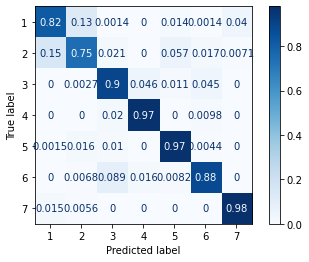

In [22]:
# Find best voting model
# 0.9110449735449736
# results_1 = []
good = [x[1] for x in good_rs]
x = 8
models = [('et'+str(y),ExtraTreesClassifier(n_jobs=-1, random_state=y, n_estimators=et_hp[y])) for y in good[:x]]
model = VotingClassifier(models, n_jobs=-1)
df_train_norm = pipeline(df_train, 3)
_, cv_acc = score_model(model,df_train_norm, display=True, return_cv_acc=True, verbose=True);

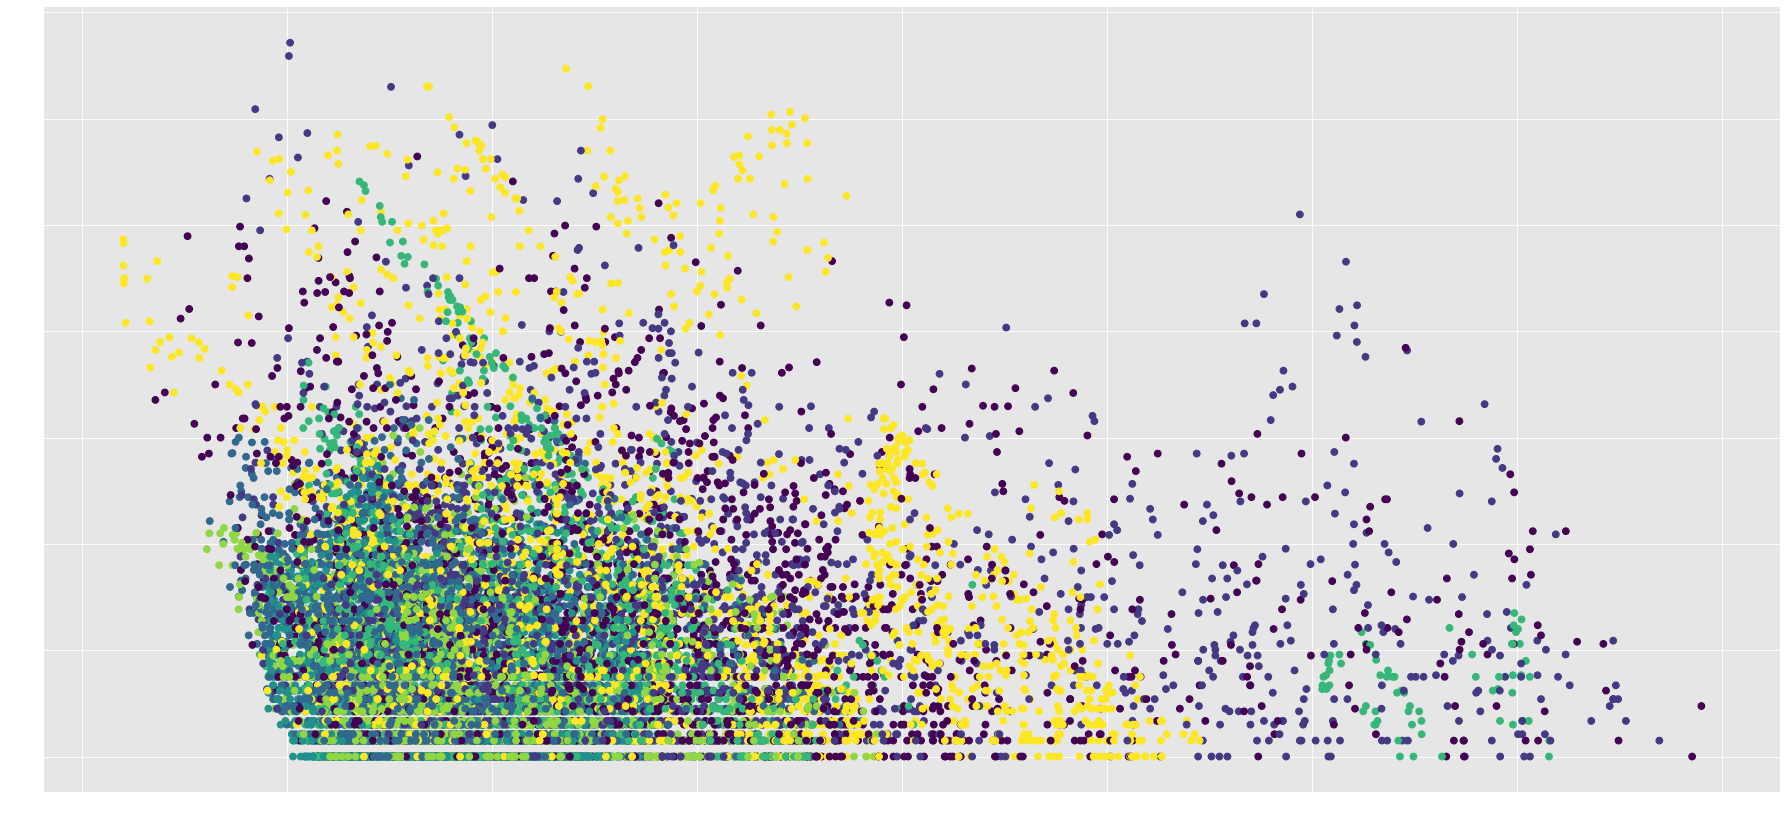

In [288]:
plt.figure(figsize=(28,13), dpi= 80)
plt.scatter(df_train.Horizontal_Distance_To_Fire_Points-df_train.Horizontal_Distance_To_Hydrology,df_train.Horizontal_Distance_To_Hydrology, c=df_train.Cover_Type)
plt.show()

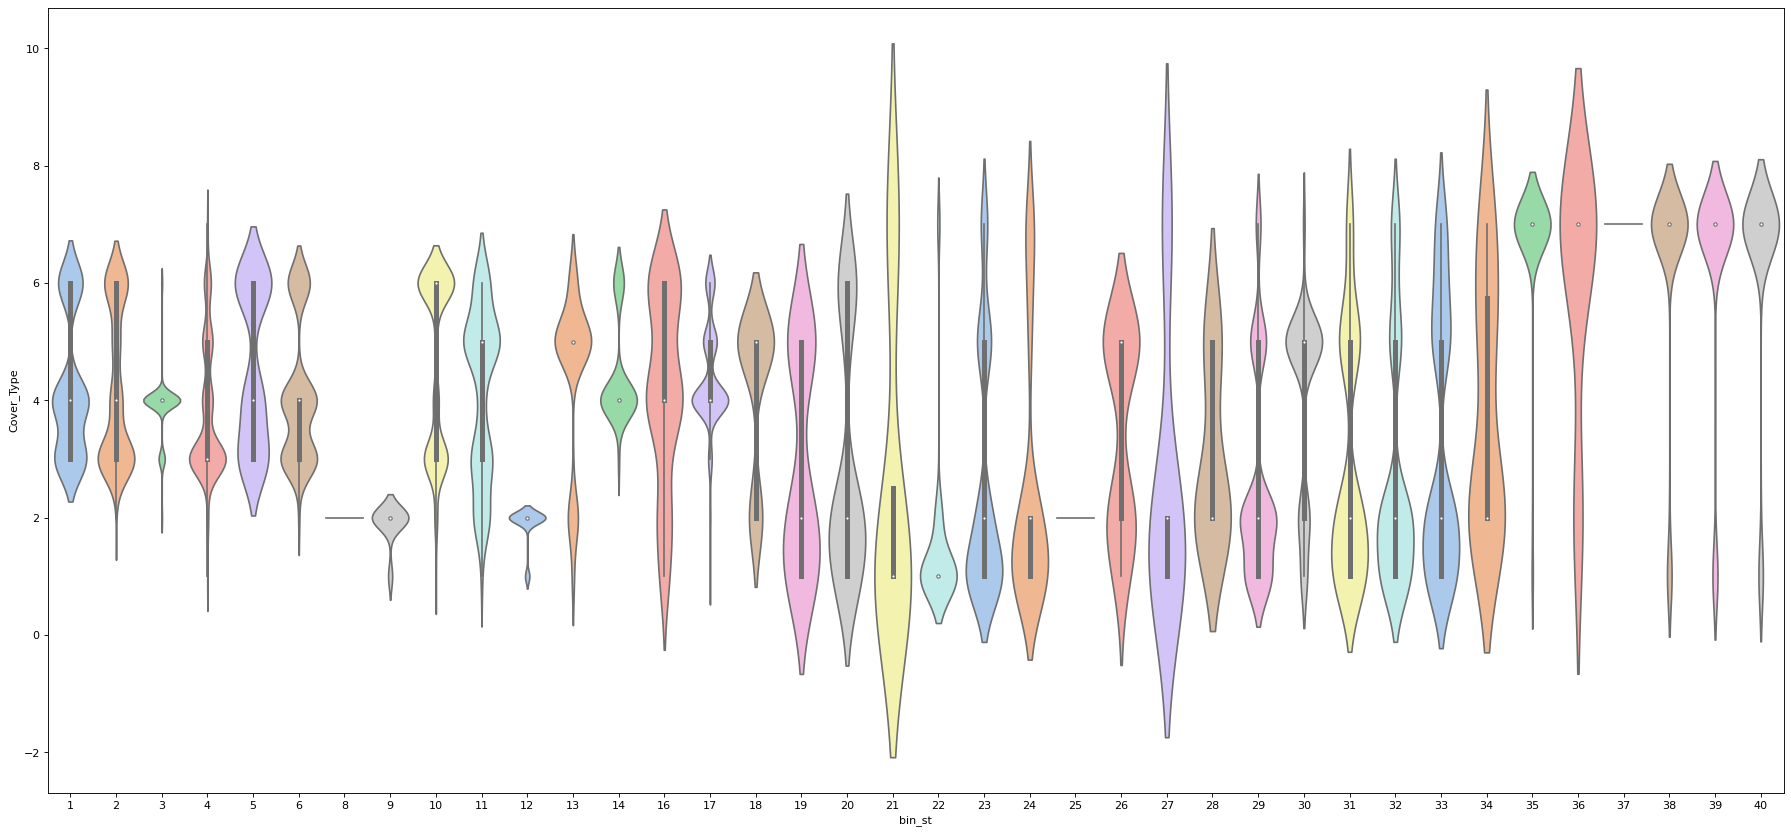

In [328]:
# for st in soil_types:
plt.figure(figsize=(28,13), dpi= 80)
sns.violinplot(x='bin_st', y='Cover_Type', data=df_soil, scale='width', inner='box', palette=sns.color_palette("pastel"))
plt.show()

# Alternative Models 

## Catboost

Reasons to Use:<br>
* missing values numeric variables
* non-encoded categorical variables
* interpretable

In [19]:
import ipywidgets as widgets
from IPython.core.display import display, clear_output
from ipywidgets import interact

In [150]:
# df = df_train
df = df_train_dir.copy()
df = df.drop(columns=['Id','Cover_Type'])
X , Y = df.to_numpy(), df_train.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)

cat_features = [df.columns.get_loc(c) for c in df.columns if "Soil_Type" in c or "Wilderness_Area" in c]

cv_dataset = Pool(data=X,
                  label=Y,
                  cat_features=cat_features,
                 )

In [152]:
params = {"iterations": 1000,
          "loss_function": "MultiClassOneVsAll", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClassOneVsAll-mean     0.871028
train-MultiClassOneVsAll-mean    0.885728
dtype: float64

In [212]:
params = {"iterations": 1000,
          "loss_function": "MultiClass", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClass-mean     0.543036
train-MultiClass-mean    0.615922
dtype: float64

In [151]:
booster = CatBoostClassifier(
#                               n_estimators=100,
#                               max_depth=10,
#                               learning_rate=0.1,
                              random_state=0,
                              objective='MultiClass', #OneVsAll
#                               iterations=100,
                              )

booster.fit(X_train, y_train, 
             cat_features = cat_features,
             plot=False, verbose=200,
             early_stopping_rounds=100,
            )

test_preds = booster.predict(X_val)
train_preds = booster.predict(X_train)

print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print("\nTest  Accuracy : %.2f"%booster.score(X_val, y_val))

for w,k in sorted(list(zip(booster.get_feature_importance(), df.columns)), key=lambda x: x[0]):
    print(k,w)

Learning rate set to 0.089045
0:	learn: 1.7615307	total: 9.55ms	remaining: 9.54s
200:	learn: 0.4557665	total: 1.52s	remaining: 6.04s
400:	learn: 0.3425556	total: 2.99s	remaining: 4.46s
600:	learn: 0.2808176	total: 4.41s	remaining: 2.93s
800:	learn: 0.2349416	total: 5.84s	remaining: 1.45s
999:	learn: 0.1996116	total: 7.27s	remaining: 0us
Train Accuracy : 0.96

Test  Accuracy : 0.85
Soil_Type8 0.0
Soil_Type15 0.0
Soil_Type37 0.0
Soil_Type25 5.3561915337154696e-05
Soil_Type9 0.00018368727561305493
Soil_Type28 0.00037792397506379935
Soil_Type36 0.0006470755969096227
Soil_Type18 0.0006998265600674246
Soil_Type21 0.002538917060706616
Soil_Type19 0.0033723456057651114
Soil_Type34 0.008996365955168315
Soil_Type27 0.009105491371237198
Soil_Type26 0.010348797227658383
Soil_Type35 0.011197475993469878
Soil_Type40 0.01725238483118321
Soil_Type14 0.017663046677007462
Soil_Type16 0.026070668009519734
Soil_Type1 0.043895398245565445
Soil_Type5 0.04508289296024852
Soil_Type20 0.07934328907748922
Wilde

### V1

In [221]:
df = pipeline(df_train, '1')
df = df.drop(columns=['Id','Cover_Type'])
X , Y = df.to_numpy(), df_train.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)

cat_features = [df.columns.get_loc(c) for c in df.columns if "Soil_Type" in c or "Wilderness_Area" in c]

cv_dataset = Pool(data=X,
                  label=Y,
                  cat_features=cat_features,
                 )

In [223]:
params = {"iterations": 1000,
          "loss_function": "MultiClassOneVsAll", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClassOneVsAll-mean     0.871065
train-MultiClassOneVsAll-mean    0.885971
dtype: float64

In [224]:
params = {"iterations": 1000,
          "loss_function": "MultiClass", # MultiClass
          "verbose": False}

scores = cv(cv_dataset,
            params=params,
            nfold=10, 
           )

1 - scores[[x for x  in scores.columns if 'mean' in x]].apply(min)

test-MultiClass-mean     0.546005
train-MultiClass-mean    0.620172
dtype: float64

In [225]:
booster = CatBoostClassifier(
#                               n_estimators=100,
#                               max_depth=10,
#                               learning_rate=0.1,
                              random_state=0,
                              objective='MultiClass', #OneVsAll
#                               iterations=100,
                              )

booster.fit(X_train, y_train, 
             cat_features = cat_features,
             plot=False, verbose=200,
             early_stopping_rounds=100,
            )

test_preds = booster.predict(X_val)
train_preds = booster.predict(X_train)

print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print("\nTest  Accuracy : %.2f"%booster.score(X_val, y_val))

for w,k in sorted(list(zip(booster.get_feature_importance(), df.columns)), key=lambda x: x[0]):
    print(k,w)

Learning rate set to 0.089045
0:	learn: 1.7681959	total: 9.45ms	remaining: 9.44s
200:	learn: 0.4571941	total: 1.46s	remaining: 5.81s
400:	learn: 0.3454389	total: 2.92s	remaining: 4.36s
600:	learn: 0.2808739	total: 4.36s	remaining: 2.9s
800:	learn: 0.2361533	total: 5.79s	remaining: 1.44s
999:	learn: 0.2007681	total: 7.23s	remaining: 0us
Train Accuracy : 0.96

Test  Accuracy : 0.84
Soil_Type8 0.0
Soil_Type15 0.0
Soil_Type37 0.0
Soil_Type25 4.5403770259579595e-05
Soil_Type9 0.0004482293929322674
Soil_Type18 0.0007010075264368416
Soil_Type28 0.0007665600967396696
Soil_Type36 0.001061361931835139
Soil_Type19 0.0018948995689125146
Soil_Type21 0.002066936234291407
Soil_Type34 0.009402121481528464
Soil_Type27 0.009488393302318267
Soil_Type26 0.01109011292942023
Soil_Type35 0.013289079594621939
Soil_Type14 0.014663916984222659
Soil_Type16 0.02253362572471905
Soil_Type1 0.031793973792809
Soil_Type5 0.04312804488253053
Soil_Type40 0.06434236752701851
Soil_Type20 0.0749656515550684
Wilderness_Area

In [225]:
booster = CatBoostClassifier(
#                               n_estimators=100,
#                               max_depth=10,
#                               learning_rate=0.1,
                              random_state=0,
                              objective='MultiClass', #OneVsAll
#                               iterations=100,
                              )

booster.fit(X_train, y_train, 
             cat_features = cat_features,
             plot=False, verbose=200,
             early_stopping_rounds=100,
            )

test_preds = booster.predict(X_val)
train_preds = booster.predict(X_train)

print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print("\nTest  Accuracy : %.2f"%booster.score(X_val, y_val))

for w,k in sorted(list(zip(booster.get_feature_importance(), df.columns)), key=lambda x: x[0]):
    print(k,w)

Learning rate set to 0.089045
0:	learn: 1.7681959	total: 9.45ms	remaining: 9.44s
200:	learn: 0.4571941	total: 1.46s	remaining: 5.81s
400:	learn: 0.3454389	total: 2.92s	remaining: 4.36s
600:	learn: 0.2808739	total: 4.36s	remaining: 2.9s
800:	learn: 0.2361533	total: 5.79s	remaining: 1.44s
999:	learn: 0.2007681	total: 7.23s	remaining: 0us
Train Accuracy : 0.96

Test  Accuracy : 0.84
Soil_Type8 0.0
Soil_Type15 0.0
Soil_Type37 0.0
Soil_Type25 4.5403770259579595e-05
Soil_Type9 0.0004482293929322674
Soil_Type18 0.0007010075264368416
Soil_Type28 0.0007665600967396696
Soil_Type36 0.001061361931835139
Soil_Type19 0.0018948995689125146
Soil_Type21 0.002066936234291407
Soil_Type34 0.009402121481528464
Soil_Type27 0.009488393302318267
Soil_Type26 0.01109011292942023
Soil_Type35 0.013289079594621939
Soil_Type14 0.014663916984222659
Soil_Type16 0.02253362572471905
Soil_Type1 0.031793973792809
Soil_Type5 0.04312804488253053
Soil_Type40 0.06434236752701851
Soil_Type20 0.0749656515550684
Wilderness_Area

In [230]:
pred = booster.predict(X_val)
acc = accuracy_score(y_val, pred)
matrix = cm(y_val, pred)
print(matrix.diagonal() / matrix.sum(axis=1))

[0.74006 0.66667 0.82497 0.96919 0.93265 0.82016 0.95792]


# Tuning Hyperparameters

In [41]:
def tune_estimator(v, rs=1189, model=''):
    df_train_norm = pipeline(df_train, v)
    tree_size_acc = []
    for n in range(100,1501,100):
        print(n, flush=True, end=' '*20+'\r')
        if model == 'ET':
            m, acc = score_model(ExtraTreesClassifier(n_estimators=n, n_jobs=-1, random_state=rs), df_train_norm, 
                                             display=False, return_cv_acc=True, return_time=False, verbose=False)
        elif model == 'RF':
            m, acc = score_model(RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=rs), df_train_norm, 
                                             display=False, return_cv_acc=True, return_time=False, verbose=False)
        else:
            m, acc = None, None
        tree_size_acc.append((n, acc))

    # fig, ax = plt.subplots()
    # # ax1 for # time
    # l1 = ax.plot(np.array(tree_size_acc)[:,1], np.array(tree_size_acc)[:,2], 'r', label='time')
    # ax.tick_params('y', colors='r')
    # ax.grid(axis='y', color='lightcoral', linestyle=':')
    # # ax2 for # n_estimators
    # ax2 = ax.twinx()
    # l2 = ax2.plot(np.array(tree_size_acc)[:,1], np.array(tree_size_acc)[:,0], 'b', label='n_estimators')
    # ax2.tick_params('y', colors='b')
    # ax2.grid(axis='y', color='royalblue', linestyle=(0,(5,5)))
    # # general plot
    # lines = l1 + l2
    # labels = [l.get_label() for l in lines]
    # ax.legend(lines,labels)
    # plt.show()
    return sorted(tree_size_acc, key=lambda x: x[1], reverse=True)[0][0]

In [197]:
df_train_norm = pipeline(df_train, 3)
tree_size_acc = []
for n in range(100,1501,100):
    print(n, flush=True, end=' '*20+'\r')
    m, acc = score_model(ExtraTreesClassifier(n_estimators=n, n_jobs=-1, random_state=rs), df_train_norm, 
                                         display=False, return_cv_acc=True, return_time=False, verbose=False)
    tree_size_acc.append((n, acc))

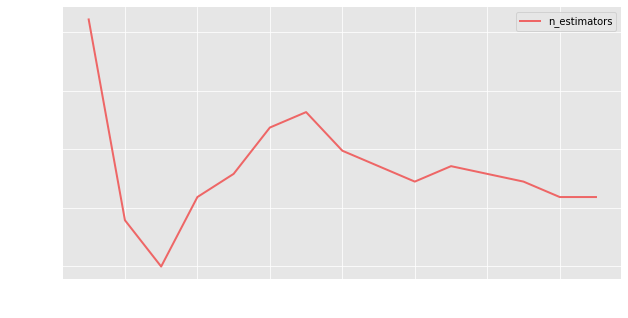

In [211]:
fig, ax = plt.subplots(figsize=(10,5))
# ax for # n_estimators
l2 = ax.plot(np.array(tree_size_acc)[:,0], np.array(tree_size_acc)[:,1], label='n_estimators')
# general plot
ax.legend()
ax.set_xlabel('N_Estimators')
ax.set_ylabel('Accuracy')
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
plt.show()

In [213]:
sorted(tree_size_acc, key=lambda x: x[1], reverse=True)[0]

(100, 0.9111111111111111)

# Result

## ET

In [9]:
df_train_norm.columns

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Cover_Type', 'log_Ho

In [ ]:
rs = 1189
for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    model = ExtraTreesClassifier(n_jobs=-1, random_state=rs)
    _, cv_acc = score_model(model,df_train_norm, display=False, return_cv_acc=True, verbose=True);

In [56]:
model_name = 'ET'
rs = 1189
for v in range(0,4):
    print(v)
    best_n = tune_estimator(v, rs, model_name)
    model = ExtraTreesClassifier(n_estimators=best_n, random_state=rs, n_jobs=-1)
    submit(model, v).to_csv('{}-{}-{}.csv'.format(model_name,v,best_n), index=False)

2
3


In [452]:
c = ['#d62728', '#268C70', 
     '#2ca02c', '#1f77b4', 
     '#9467bd', '#608475', 
     '#e377c2', '#BC6FC0', 
     '#d62728']

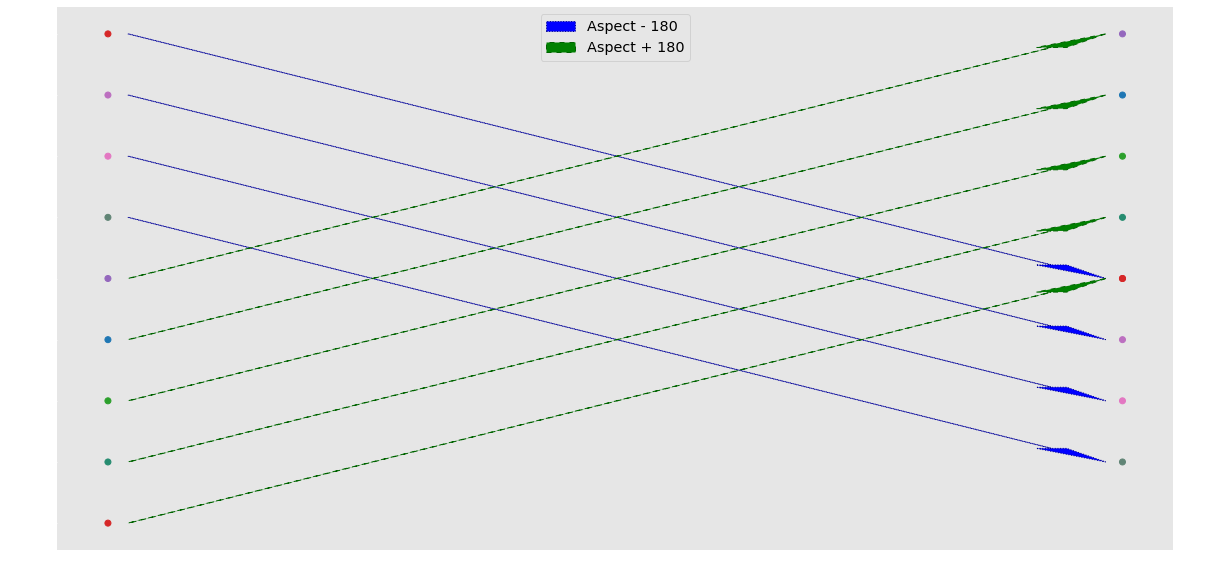

In [453]:
fig, ax = plt.subplots(figsize=(20,10))

# ax1 for original
ax.scatter([1]*len(np.arange(0,361,45)), np.arange(0,361,45), c=c)
ax.set_ylim((-20,380))
ax.set_xticks([])
ax.set_yticks(np.arange(0,361,45))
ax.set_ylabel('Original Aspect', c='w', size='x-large')
ax.set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'], fontsize='x-large')

# ax2 for transformed
ax2 = ax.twinx()
ax2.scatter([2]*len(np.arange(0,361,45)), [x-180 if x > 180 else x+180 for x in np.arange(0,361,45)], c=c)
ax2.set_ylim((-20,380))
ax2.set_xticks([])
ax2.set_ylabel('Transformed Aspect', c='w', size='x-large')
ax2.set_yticks(np.arange(45,361,45))
ax2.set_yticklabels(['SW','W','NW','N','NE','E','SE','S'], fontsize='x-large')

v = .02
for i in range(4):
    if i == 0:
        ax.arrow(1+v, 360-i*45, 
                 1-v*4.5, -180+10, head_width=0.03, head_length=10, fc='blue', ec='darkblue', ls=':', 
                 label='Aspect - 180')
    else: 
        ax.arrow(1+v, 360-i*45, 
             1-v*4.5, -180+10, head_width=0.03, head_length=10, fc='blue', ec='darkblue', ls=':')
for i in range(5):
    if i == 0:
        ax.arrow(1+v, 0+i*45, 
                 1-v*4.5, 180-10, head_width=0.03, head_length=10, fc='green', ec='darkgreen', ls=(0,(5,5)),
                label ='Aspect + 180')
    else:
        ax.arrow(1+v, 0+i*45, 
                 1-v*4.5, 180-10, head_width=0.03, head_length=10, fc='green', ec='darkgreen', ls=(0,(5,5)))
ax.grid(False)
ax2.grid(False)
ax.legend(loc='upper center', fontsize='x-large')
plt.show()

[180, 225, 270, 315, 360, 45, 90, 135, 180]

In [277]:
np.arctan(np.arange(0,361,45))

array([0.     , 1.54858, 1.55969, 1.56339, 1.56524, 1.56635, 1.56709,
       1.56762, 1.56802])

## ET Voting

In [17]:
ets_model = [{'name': 'et1189', 'rs': 1189, 'n_tree': 100},
             {'name': 'et883', 'rs': 883, 'n_tree': 100},
             {'name': 'et2153', 'rs': 2153, 'n_tree': 100},
             {'name': 'et5568', 'rs': 5568, 'n_tree': 100},
             {'name': 'et2077', 'rs': 2077, 'n_tree': 100},
             {'name': 'et769', 'rs': 769, 'n_tree': 100},
             {'name': 'et2223', 'rs': 2223, 'n_tree': 100},
             {'name': 'et2675', 'rs': 2675, 'n_tree': 100}]
models = [(y['name'],ExtraTreesClassifier(n_jobs=-1, random_state=y['rs'], n_estimators=y['n_tree'])) for y in ets_model]

for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    model = VotingClassifier(models, n_jobs=-1)
    _, cv_acc = score_model(model,df_train_norm, display=False, return_cv_acc=True, verbose=True);

0
cv acc: 0.8687830687830689
split acc: 0.855310621242485
time taken: 48.9494993686676

1
cv acc: 0.892989417989418
split acc: 0.8781563126252505
time taken: 45.50850176811218

2
cv acc: 0.8975529100529099
split acc: 0.8811623246492986
time taken: 45.32349872589111

3
cv acc: 0.9130952380952382
split acc: 0.8935871743486974
time taken: 45.23699951171875



In [57]:
model_name = 'ET_Voting'
ets_model = [{'name': 'et1189', 'rs': 1189, 'n_tree': 100},
             {'name': 'et883', 'rs': 883, 'n_tree': 100},
             {'name': 'et2153', 'rs': 2153, 'n_tree': 100},
             {'name': 'et5568', 'rs': 5568, 'n_tree': 100},
             {'name': 'et2077', 'rs': 2077, 'n_tree': 100},
             {'name': 'et769', 'rs': 769, 'n_tree': 100},
             {'name': 'et2223', 'rs': 2223, 'n_tree': 100},
             {'name': 'et2675', 'rs': 2675, 'n_tree': 100}]
models = [(y['name'],ExtraTreesClassifier(n_jobs=-1, random_state=y['rs'], n_estimators=y['n_tree'])) for y in ets_model]

for v in range(0,4):
    print(v)
    model = VotingClassifier(models, n_jobs=-1)
    submit(model, v).to_csv('{}-{}.csv'.format(model_name,v), index=False)

0
1
2
3


## RF

In [18]:
rs = 1189
for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    model = RandomForestClassifier(n_jobs=-1, random_state=rs)
    _, cv_acc = score_model(model,df_train_norm, display=False, return_cv_acc=True, verbose=True);

0
cv acc: 0.8653439153439153
split acc: 0.8448897795591183
time taken: 6.475813627243042

1
cv acc: 0.8814814814814815
split acc: 0.8637274549098196
time taken: 6.1565680503845215

2
cv acc: 0.8802910052910052
split acc: 0.8627254509018036
time taken: 6.101942300796509

3
cv acc: 0.8931878306878307
split acc: 0.8725450901803607
time taken: 6.807998418807983



In [58]:
model_name = 'RF'
rs = 1189
for v in range(0,4):
    print(v)
    best_n = tune_estimator(v, rs, model_name)
    model = RandomForestClassifier(n_estimators=best_n, random_state=rs, n_jobs=-1)
    submit(model, v).to_csv('{}-{}-{}.csv'.format(model_name,v,best_n), index=False)

0
1500                    
2500                    
3500                    


## CatBoost

In [31]:
for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    cat_features = [df_train_norm.columns.get_loc(c) for c in df_train_norm.columns if "Soil_Type" in c or "Wilderness_Area" in c]
    model = CatBoostClassifier(
                cat_features=cat_features,
                random_state=None,
                objective='MultiClass',
                verbose=False
                )
    _, cv_acc = score_model(model,df_train_norm, display=False, return_cv_acc=True, verbose=True);

0
cv acc: 0.8593915343915345
time taken: 77.38750219345093

1
cv acc: 0.8621693121693121
time taken: 82.54449772834778

2
cv acc: 0.8628968253968254
time taken: 82.43399739265442

3
cv acc: 0.8755952380952381
time taken: 96.33850049972534



In [60]:
model_name = 'CatBoost'
for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    cat_features = [df_train_norm.columns.get_loc(c) for c in df_train_norm.columns if "Soil_Type" in c or "Wilderness_Area" in c]
    model = CatBoostClassifier(
                cat_features=cat_features,
                objective='MultiClass',
                verbose=False
                )
    submit(model, v).to_csv('{}-{}.csv'.format(model_name,v), index=False)

0
1
2
3


# Plot results

In [191]:
from matplotlib import cycler
cs = ['#EE6666', '#7abf0a', '#9988DD',
      '#EECC55', '#88BB44', '#3a32d1',
      '#391306', '#3388BB', '#1DC690']
colors = cycler('color', cs)
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='w')
plt.rc('ytick', direction='out', color='w')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

## pipeline version acc change

In [234]:
pv_acc = []
rs = 1189
for v in range(0,4):
    print(v)
    df_train_norm = pipeline(df_train, v)
    model = ExtraTreesClassifier(n_jobs=-1, random_state=rs)
    _, class_acc = score_model(model,df_train_norm, display=False, return_cv_acc=False, verbose=True, return_class_acc=True);
    pv_acc.append((v,*class_acc))

0
cv acc: 0.8683201058201057
time taken: 7.667465686798096

1
cv acc: 0.8909391534391535
time taken: 6.404084920883179

2
cv acc: 0.8965608465608467
time taken: 6.045872688293457

3
cv acc: 0.9111111111111111
time taken: 5.636249542236328



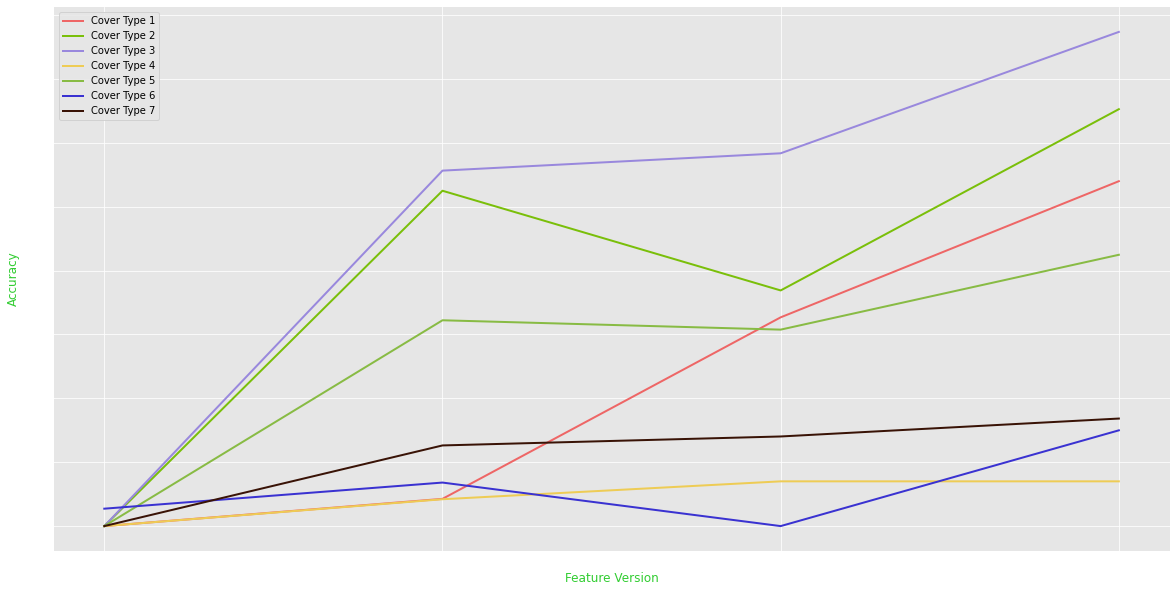

In [271]:
pv_df = pd.DataFrame(pv_acc)
fig, ax = plt.subplots(figsize=(20,10))

for x in range(1,pv_df.shape[1]):
    ax.plot(pv_df[0], pv_df[x] - pv_df[x].min(), label='Cover Type {}'.format(x))
    
ax.set_xticks([0,1,2,3])
ax.set_xlabel('Feature Version')
ax.set_ylabel('Accuracy')
ax.xaxis.label.set_color('limegreen')
ax.xaxis.label.set_size('large')
ax.yaxis.label.set_color('limegreen')
ax.yaxis.label.set_size('large')
ax.legend()
plt.show()

## Plot Acc

In [64]:
result_df = pd.read_excel('model_results.xlsx')
result_df

,version,model,acc,time,k_acc
0,0,ET,0.868320,5.991983,0.75735
1,0,ET Voting,0.868783,48.949499,0.75934
2,0,RF,0.865344,6.475814,0.75432
3,0,Catboost,0.859392,77.387502,0.73891
4,1,ET,0.890939,5.786227,0.79727
5,1,ET Voting,0.892989,45.508502,0.79789
6,1,RF,0.881481,6.156568,0.78393
7,1,Catboost,0.862169,82.544498,0.74616
8,2,ET,0.896561,5.622958,0.80055
9,2,ET Voting,0.897553,45.323499,0.80125


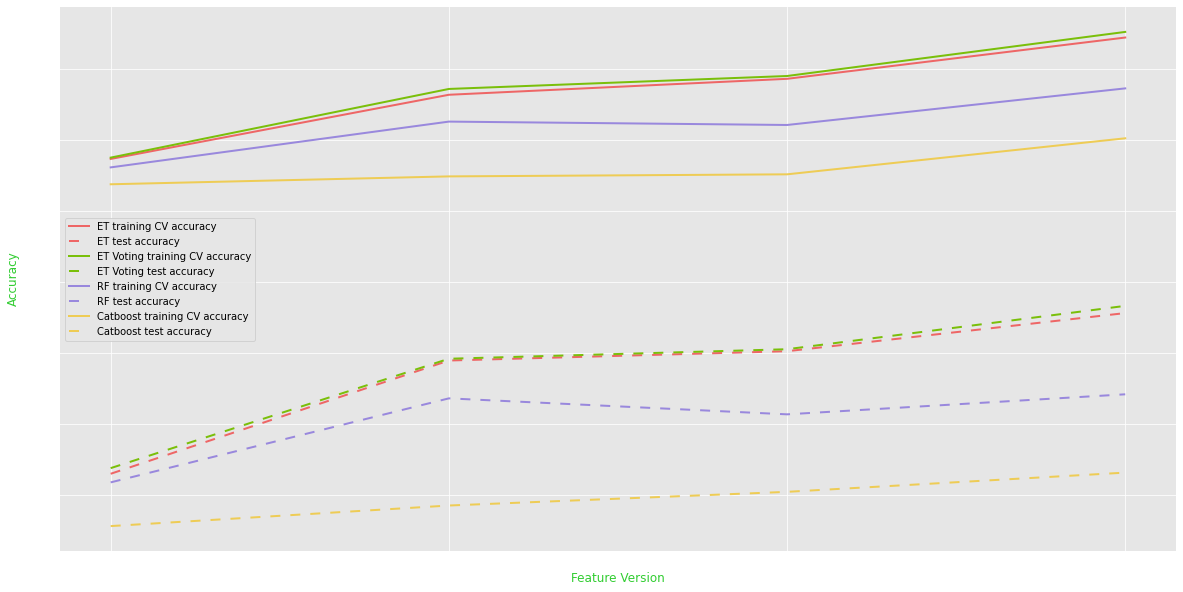

In [214]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

# cmap = plt.cm.get_cmap('copper',len(result_df.model.unique()))
for i, model_name in enumerate(result_df.model.unique()):
    df_r = result_df[result_df.model == model_name]
    ax.plot(df_r.version, df_r.acc, label='{} training CV accuracy'.format(model_name), c=cs[i])
    ax.plot(df_r.version, df_r.k_acc, linestyle='--', dashes=(5,5) , label='{} test accuracy'.format(model_name), c=cs[i])
    
ax.set_xticks([0,1,2,3])
ax.set_xlabel('Feature Version')
ax.set_ylabel('Accuracy')
ax.xaxis.label.set_color('limegreen')
ax.xaxis.label.set_size('large')
ax.yaxis.label.set_color('limegreen')
ax.yaxis.label.set_size('large')
ax.legend()
plt.show()

## Plot Time

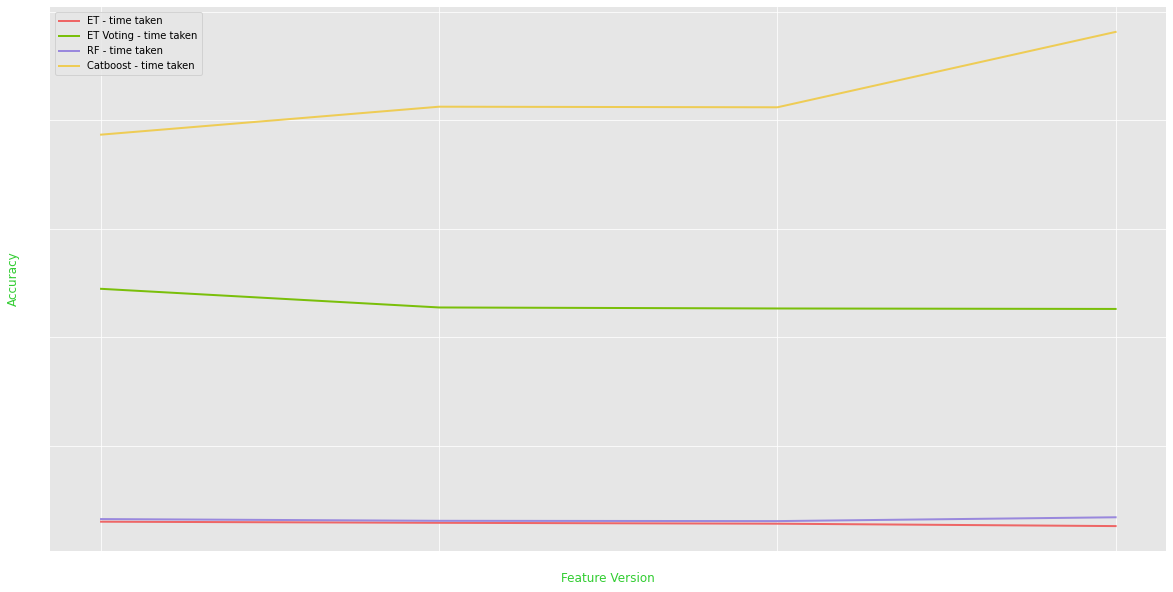

In [206]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

for i, model_name in enumerate(result_df.model.unique()):
    df_r = result_df[result_df.model == model_name]
    ax.plot(df_r.version, df_r.time, label='{} - time taken'.format(model_name), c=cs[i])
    
ax.set_xticks([0,1,2,3])
ax.set_xlabel('Feature Version')
ax.set_ylabel('Accuracy')
ax.xaxis.label.set_color('limegreen')
ax.xaxis.label.set_size('large')
ax.yaxis.label.set_color('limegreen')
ax.yaxis.label.set_size('large')
ax.legend()
plt.show()